In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import morphology
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from config import *

In [74]:
class DataLoader:
    __slots__ = ('images', '__index', 'labels', '_size', 'data')
    shape = (224, 224, 1)
    
    def __init__(self, _path: str) -> None:
        self.data = pd.read_csv(_path)
        self.__index, self._size = 0, self.data.shape[0]
        
        self.images = np.empty((self._size,) + self.shape, dtype='float16')
        self.labels = np.empty(self._size, dtype='uint8')

    def load_data(self) -> None:
        for _, _path, _categories in self.data.values:
            self.add_image(_path, _categories)

    def add_image(self, _path: str, category: int) -> None:
        image_path = f"data/train/{CATEGORIES_REVERSE[category]}/{_path}"
        image = cv2.imread(image_path, 0) / 255
        
        image.reshape(224, 224)
        image = morphology.skeletonize(image < 0.5)
        
        self.images[self.__index] = np.asarray(image, dtype='float16').reshape(self.shape)
        self.labels[self.__index] = category
        self.__index += 1

        print(f"[+] Progress: {self.__index}/{self._size}", end='\r')
        
        if self.__index == self._size:
            self.labels = to_categorical(self.labels)
            print(f"\n[+] DONE")
            
    def show_image(self, index: int) -> None:
        plt.imshow(self.images[index], cmap='gray')

[+] Progress: 14629/14629
[+] DONE


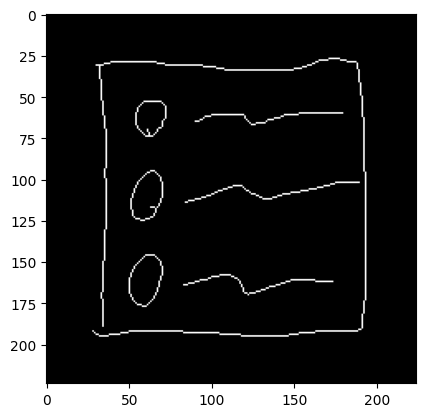

In [3]:
train_set_path = 'data/processed/train_set.csv'
train_data = DataLoader(train_set_path)
train_data.load_data()
train_data.show_image(302)

In [8]:
class SketchClassificatorModel:
    __slots__ = ('_data', '_shape', 'num_classes', 'model', 'version')
    
    def __init__(self, data) -> None:
        self._data = data
        self._shape = data.shape
        self.num_classes = len(CATEGORIES_CODES)
        self.model = models.Sequential()

    def build_model(self) -> None:
        activation, final_activation = 'relu', 'softmax'
        kernel_size, pool_size = (6, 6), (4, 4)
        
        self.model.add(layers.Conv2D(32, kernel_size, activation=activation, input_shape=self._shape))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(64, kernel_size=kernel_size, activation=activation))
        #self.model.add(layers.Dropout(0.4))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(128, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(128, activation=activation))
        self.model.add(layers.Dropout(0.4))
        self.model.add(layers.Dense(self.num_classes, activation=final_activation))
        
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train(self) -> None:
        self.model.fit(self._data.images, self._data.labels, epochs=10, batch_size=64, validation_split=0.05)
    
    def save(self, version: str) -> None:
        self.model.save(f'models/model_v{version}.h5')

In [9]:
sketch_model = SketchClassificatorModel(train_data)
sketch_model.build_model()
sketch_model.train()

Epoch 1/10
218/218 [==============================] - 168s 765ms/step - loss: 1.9857 - accuracy: 0.3996 - val_loss: 1.3491 - val_accuracy: 0.5738
Epoch 2/10
218/218 [==============================] - 165s 755ms/step - loss: 1.2922 - accuracy: 0.6020 - val_loss: 1.1053 - val_accuracy: 0.6503
Epoch 3/10
218/218 [==============================] - 162s 743ms/step - loss: 1.0647 - accuracy: 0.6722 - val_loss: 1.0564 - val_accuracy: 0.6708
Epoch 4/10
218/218 [==============================] - 170s 779ms/step - loss: 0.8866 - accuracy: 0.7199 - val_loss: 0.9574 - val_accuracy: 0.7145
Epoch 5/10
218/218 [==============================] - 163s 746ms/step - loss: 0.7456 - accuracy: 0.7640 - val_loss: 0.9268 - val_accuracy: 0.7295
Epoch 6/10
218/218 [==============================] - 209s 958ms/step - loss: 0.6167 - accuracy: 0.8043 - val_loss: 0.9656 - val_accuracy: 0.7254
Epoch 7/10
218/218 [==============================] - 270s 1s/step - loss: 0.5292 - accuracy: 0.8290 - val_loss: 0.8997 - va

In [10]:
#the last version + 0.1 to create new_version
#new_model_version = float(os.listdir('models')[-1][7:-3])+0.1  

new_model_version='0.2.2'
sketch_model.save(new_model_version)
#del sketch_model

C:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
test_set_path = 'data/processed/test_set.csv'
test_data = DataLoader(test_set_path)
test_data.load_data()

[+] Progress: 770/770
[+] DONE


In [6]:
#test_data.show_image(300)

In [12]:
for models in os.listdir('models'):
    model_test = load_model(f'models/{models}')
    print(f'Model version: {models[7:-3]}')
    test_loss, test_accuracy = model_test.evaluate(test_data.images, test_data.labels)

Model version: 0.1
25/25 [==============================] - 4s 154ms/step - loss: 3.6887 - accuracy: 0.4727
Model version: 0.2
25/25 [==============================] - 3s 111ms/step - loss: 2.2219 - accuracy: 0.6078
Model version: 0.30000000000000004
25/25 [==============================] - 3s 111ms/step - loss: 1.0388 - accuracy: 0.7481


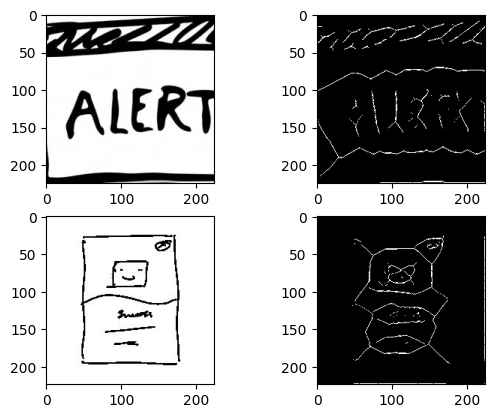

In [72]:
def img_skeletonizing(image):
    _, img_ = cv2.threshold(image, 127, 255, 0)
    
    skeleton = np.zeros(img_.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    
    while True:
        open_img = cv2.morphologyEx(img_, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(img_, open_img)
        eroded = cv2.erode(img_, element)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img_ = eroded.copy()
        if cv2.countNonZero(img_)==0:
            break
    
    return skeleton
        
img_index=4
img1 = cv2.imread(f"data/train/alert/{os.listdir('data/train/alert/')[img_index]}", 0)

index=5
img2 = cv2.imread(f"data/train/alert/{os.listdir('data/train/alert/')[img_index]}", 0)

fig = plt.figure()

fig.add_subplot(2, 2, 1) 
plt.imshow(img1, cmap='gray')
fig.add_subplot(2, 2, 2) 
plt.imshow(img_skeletonizing(img1), cmap='gray')

fig.add_subplot(2, 2, 3) 
plt.imshow(img2, cmap='gray')
fig.add_subplot(2, 2, 4) 
plt.imshow(img_skeletonizing(img2), cmap='gray')